In [15]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

from google.colab import files
uploaded = files.upload()

Saving hanoi_quality.csv to hanoi_quality.csv


In [17]:
# Function to smooth data
def smoothed(data, window_size=5):
    forecast_smoothed = data.rolling(window=window_size).mean()
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')
    return forecast_smoothed_filled

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df0=df.reset_index()['pm25']
print(df0.shape)

# Làm mượt dữ liệu
df1 = smoothed(df0)

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1.shape)

(1920,)
(1920, 1)


In [18]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----29   Y=30
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+30 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)


In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 56ms/step - loss: 0.0321
Epoch 2/100
21/21 [==============================] - 1s 56ms/step - loss: 0.0182
Epoch 3/100
21/21 [==============================] - 1s 56ms/step - loss: 0.0171
Epoch 4/100
21/21 [==============================] - 1s 64ms/step - loss: 0.0170
Epoch 5/100
21/21 [==============================] - 2s 88ms/step - loss: 0.0164
Epoch 6/100
21/21 [==============================] - 2s 87ms/step - loss: 0.0158
Epoch 7/100
21/21 [==============================] - 1s 57ms/step - loss: 0.0153
Epoch 8/100
21/21 [==============================] - 1s 55ms/step - loss: 0.0147
Epoch 9/100
21/21 [==============================] - 1s 56ms/step - loss: 0.0138
Epoch 10/100
21/21 [==============================] - 2s 80ms/step - loss: 0.0127
Epoch 11/100
21/21 [==============================] - 2s 105ms/step - loss: 0.0107
Epoch 12/100
21/21 [==============================] - 1s 55ms/step - loss: 0.0096
Epoch 13/100
21/21 [====

In [20]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))

18/18 [==============================] - 3s 7ms/step


In [21]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

ytest=scaler.inverse_transform(test_data)

# Làm mượt dự đoán\
y_pred = smoothed(pd.Series(y_pred.flatten())).values.reshape(-1, 1)

# 12. Đánh giá mô hình
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 50.992922747917326
Testing MAE: 46.98252337608072
Testing MAPE: 55.33271490410795


In [23]:
x_input=test_data[30:].reshape(1,-1)
x_input.shape

(1, 546)

In [24]:
# 13. Dự báo 90 ngày tiếp theo
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=546
i=0
while i < 90:
    #print(f"Starting iteration {i}, len(temp_input): {len(temp_input)}")
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, n_steps, 1))

    yhat = model.predict(x_input, verbose=0)
    #print(f"{i + 1} day output {yhat}")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i += 1

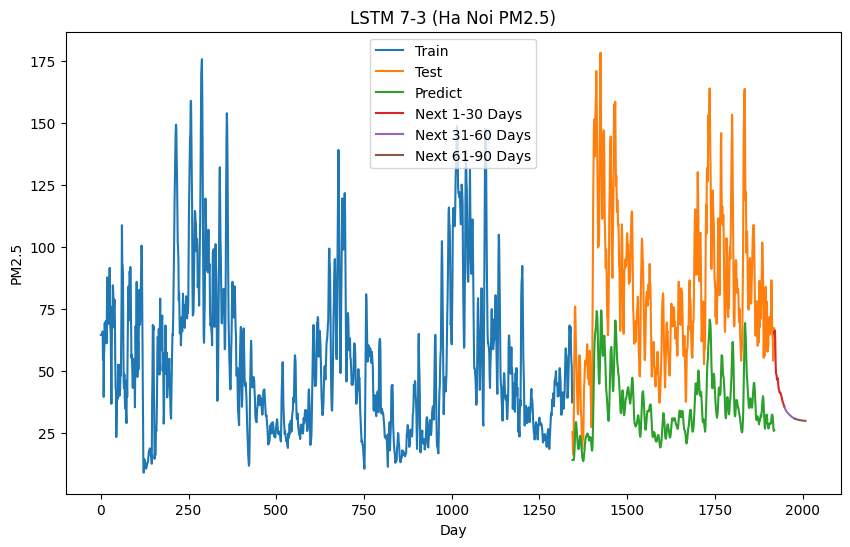

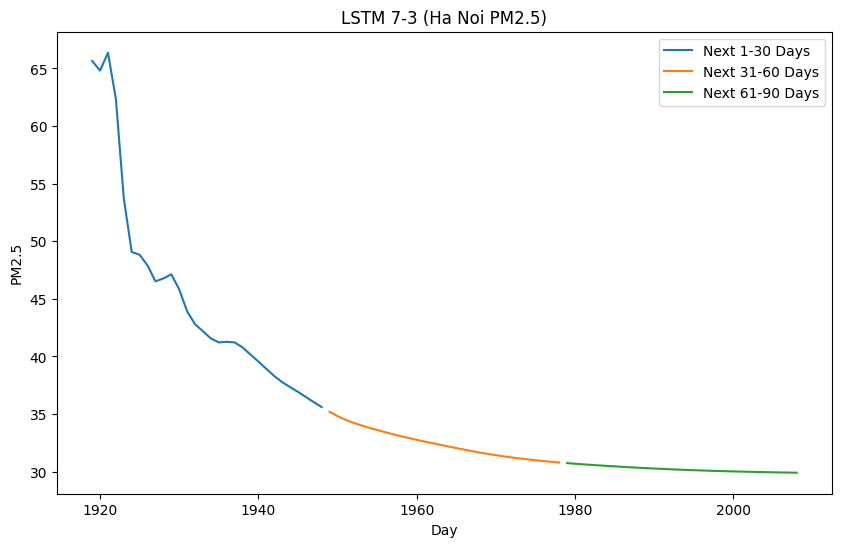

In [25]:
# 14.Vẽ hình
plt.figure(figsize=(10, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 7-3 (Ha Noi PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

# Dự đoán 90 ngày tiếp theo
plt.figure(figsize=(10, 6))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 7-3 (Ha Noi PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

In [26]:
print(scaler.inverse_transform(lst_output))

[[65.65239306]
 [64.81358761]
 [66.36545519]
 [62.35530487]
 [53.72263975]
 [49.07139386]
 [48.82694484]
 [47.90244339]
 [46.52222274]
 [46.77203833]
 [47.13266121]
 [45.82804205]
 [43.91666982]
 [42.80181923]
 [42.18855358]
 [41.56432005]
 [41.22532247]
 [41.27528256]
 [41.22308598]
 [40.78669248]
 [40.17083442]
 [39.5621806 ]
 [38.93590746]
 [38.30761239]
 [37.77726353]
 [37.34858416]
 [36.93120337]
 [36.48487692]
 [36.03727824]
 [35.60792237]
 [35.19852075]
 [34.82577133]
 [34.51021905]
 [34.24819615]
 [34.01997053]
 [33.81187838]
 [33.61831838]
 [33.43395172]
 [33.25524192]
 [33.08357984]
 [32.92143673]
 [32.76790387]
 [32.61995466]
 [32.47528446]
 [32.332669  ]
 [32.19147723]
 [32.0521635 ]
 [31.91632062]
 [31.78584684]
 [31.66203963]
 [31.54545178]
 [31.43633574]
 [31.33457285]
 [31.23989808]
 [31.15193783]
 [31.07043968]
 [30.99513605]
 [30.92553725]
 [30.86113336]
 [30.80125547]
 [30.74522959]
 [30.69243981]
 [30.64235856]
 [30.59454913]
 [30.5487465 ]
 [30.50480424]
 [30.46254